In [1]:
#Import packages
import numpy as np       
import pandas as pd      
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import os
import gc

# Overview

train.csv

* row_id: (int64) ID code for the row.

* timestamp: (int64) the time between this user interaction and the first event from that user.

* user_id: (int32) ID code for the user.

* content_id: (int16) ID code for the user interaction

* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

* prior_question_elapsed_time: (float32) How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

# Data Pre-Processing & Feature Engineering

In [3]:
#Reading data
full_train = pd.read_csv('train.csv')
questions = pd.read_csv('questions.csv')
question_comm = pd.read_csv('question_cmnts.csv')

In [4]:
full_train.head(5)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [5]:
questions.head(5)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [6]:
question_comm.head(5)

,Unnamed: 0,community
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


In [7]:
# Remove unnecessary columns 
full_train = full_train[['row_id','user_id','content_id','content_type_id','answered_correctly']]

In [8]:
## So far this method does not help increase the score so leave it here for further implementation 

## eliminate the question with missing tag value
# questions[questions.tags.isna()]
# questions = questions[questions.tags.notna()]
# questions.shape

## drop the interactions with that question with missing tag value
# print(full_train.shape)
# nantagQ = full_train.query('content_id == "10033" and answered_correctly != -1')
# full_train = full_train.drop(nantagQ.index)
# print(full_train.shape)

In [9]:
#Dictionnary for questions average
#select those rows with answering questions and group by 'contene id' and take the average on 'answered_correctly'
question_average = pd.DataFrame(full_train.loc[full_train['content_type_id'] == 0].groupby(['content_id'])['answered_correctly'].mean()).rename(columns={'answered_correctly':'question_average'})
question_count = pd.DataFrame(full_train.loc[full_train['content_type_id'] == 0].groupby(['content_id']).size(),columns=['question_count'])

#Joining average and count
question_df = question_average.join(question_count)

#Computing sum as product of average and count
question_df['question_sum'] = question_df['question_average'] * question_df['question_count']

#Joining the new dataframe with questions data, getting more columns
question_df = question_df.join(questions,how='outer')[['question_average','question_count','question_sum']]
question_df = question_df.reset_index()
question_df['community'] = question_comm['community']

question_df.head(5)

,content_id,question_average,question_count,question_sum,community
0,0,0.907721,6903,6266.0,2
1,1,0.890646,7398,6589.0,2
2,2,0.554281,44905,24890.0,2
3,3,0.779437,22973,17906.0,2
4,4,0.613215,31736,19461.0,2


In [10]:
del question_comm, question_average, question_count
gc.collect()

20

In [11]:
# Reduce the size of our training dataset for memory efficiency 
train = full_train.groupby('user_id').tail(400)
test = full_train.groupby('user_id').tail(4)
train = train.drop(test.index)
del full_train
gc.collect()

20

In [12]:
# Remove the rows that content_id are not questions
train = train.loc[train['content_type_id'] == False]

In [13]:
# Find the overall mean accuracy of all users and questions
mean_user = train.groupby(['user_id'])['answered_correctly'].mean().mean()
mean_question = train.groupby(['content_id'])['answered_correctly'].mean().mean()

In [14]:
# Join the questions dictionary with train dataset
train = train.join(question_df[['question_average']], on=['content_id'],rsuffix='_right')
train.head(5)

,row_id,user_id,content_id,content_type_id,answered_correctly,question_average
0,0,115,5692,0,1,0.745495
1,1,115,5716,0,1,0.734901
2,2,115,128,0,1,0.966869
3,3,115,7860,0,1,0.954815
4,4,115,7922,0,1,0.953218


In [15]:
# Find the 'average_past_questions' feature
train['user_shift_question'] = train.groupby(['user_id'])['question_average'].shift()
cumulated_question = train.groupby(['user_id'])['user_shift_question'].agg(['cumsum','cumcount'])
train['average_past_questions'] = cumulated_question['cumsum'] / (cumulated_question['cumcount'] + 1)
train.drop(columns=['user_shift_question'],inplace=True)
train['average_past_questions'].fillna(mean_question,inplace=True)
del cumulated_question

In [16]:
train.head(5)

,row_id,user_id,content_id,content_type_id,answered_correctly,question_average,average_past_questions
0,0,115,5692,0,1,0.745495,0.697522
1,1,115,5716,0,1,0.734901,0.372747
2,2,115,128,0,1,0.966869,0.493465
3,3,115,7860,0,1,0.954815,0.611816
4,4,115,7922,0,1,0.953218,0.680416


In [17]:
#Computing the average for each user depending only on past events
train['user_shift'] = train.groupby(['user_id'])['answered_correctly'].shift()
cumulated = train.groupby(['user_id'])['user_shift'].agg(['cumsum', 'cumcount'])
train['answered_correctly_user_average'] = cumulated['cumsum'] / cumulated['cumcount']

del cumulated
train.drop(columns=['user_shift'], inplace=True)
gc.collect()

train['answered_correctly_user_average'].fillna(mean_user,inplace=True)

In [18]:
train.head(5)

,row_id,user_id,content_id,content_type_id,answered_correctly,question_average,average_past_questions,answered_correctly_user_average
0,0,115,5692,0,1,0.745495,0.697522,0.546486
1,1,115,5716,0,1,0.734901,0.372747,1.000000
2,2,115,128,0,1,0.966869,0.493465,1.000000
3,3,115,7860,0,1,0.954815,0.611816,1.000000
4,4,115,7922,0,1,0.953218,0.680416,1.000000


In [19]:
#Dictionnary for user average
user_average = pd.DataFrame(train.groupby(['user_id'])['answered_correctly_user_average'].last()).rename(columns={'answered_correctly_user_average':'user_average'})
#Dictionnary for user count
user_count = pd.DataFrame(train.groupby(['user_id']).size() - 1,columns=['user_count'])

In [20]:
# Compute the 'performance_before' feature
train['performance_before'] = train['answered_correctly_user_average'] - train['average_past_questions']
user_performance = pd.DataFrame(train.loc[train['content_type_id'] == 0].groupby(['user_id'])['performance_before'].last()).rename(columns={'performance_before':'performance'})
train.drop(columns=['performance_before', 'average_past_questions', 'answered_correctly_user_average'], inplace=True)
train.head(3)

,row_id,user_id,content_id,content_type_id,answered_correctly,question_average
0,0,115,5692,0,1,0.745495
1,1,115,5716,0,1,0.734901
2,2,115,128,0,1,0.966869


In [21]:
# Create the user dictionary
user_df = user_performance.join(user_average).join(user_count)
user_df['user_sum'] = user_df['user_average'] * user_df['user_count']
user_df.head(5)

,performance,user_average,user_count,user_sum
user_id,,,,
115,-0.005266,0.731707,41,30.0
124,-0.142335,0.280000,25,7.0
2746,-0.093102,0.571429,14,8.0
5382,0.030907,0.683333,120,82.0
8623,0.046685,0.634615,104,66.0


In [22]:
question_df.head(5)

,content_id,question_average,question_count,question_sum,community
0,0,0.907721,6903,6266.0,2
1,1,0.890646,7398,6589.0,2
2,2,0.554281,44905,24890.0,2
3,3,0.779437,22973,17906.0,2
4,4,0.613215,31736,19461.0,2


In [23]:
# Function to find and update the user's accuracy and correct answers
def question_average_sum_by_user(df,question_df):
    my_dict = {}
    group = df.groupby(['user_id'])
    for user, val in group:
        average_sum = 0.0
        for row_index, row in val.iterrows():
            if (row['content_type_id'] == False):
                question_id = row['content_id']
                question_average = question_df.at[question_id,'question_average']
                average_sum += question_average
                #the 'print' can be commented
                print(f'user = {user}, id = {question_id}, average = {question_average}, average_sum={average_sum}')
        my_dict[user] = [average_sum]
    return pd.DataFrame.from_dict(my_dict,orient='index',columns=['question_average_sum'])

In [24]:
# Function to add answers statistics variables to a batch of testing dataset
def add_answers_to_prior_df(current_df,prior_df):
    prior_df_ = prior_df.copy()
    if (prior_df.shape[0] > 0):
        val = eval(current_df.iloc[0]['prior_group_answers_correct'])
        if (len(val) == prior_df.shape[0]):
            prior_df_['answered_correctly_response'] = val
    return prior_df_

In [25]:
# Function to build and update on the questions dictionary from data
def build_question_df(prior_df,question_df):
    
    if (prior_df.shape[0] == 0):
        return question_df
    
    #Dictionnary for questions average
    question_sum_prior = pd.DataFrame(prior_df.loc[prior_df['content_type_id'] == 0]\
                           .groupby(['content_id'])['answered_correctly_response'].sum())\
                           .rename(columns={'answered_correctly_response':'question_sum'})
    
    #Dictionnary for questions count
    question_count_prior = pd.DataFrame(prior_df.loc[prior_df['content_type_id'] == 0]\
                             .groupby(['content_id']).size(),columns=['question_count'])
    
    #Joining the two previous dataframes in one
    question_df = question_df.join(question_sum_prior,rsuffix='_previous').join(question_count_prior,rsuffix='_previous')
    
    #Filling null values
    question_df['question_average'].fillna(0,inplace=True)
    question_df['question_count'].fillna(0,inplace=True)
    question_df['question_sum'].fillna(0,inplace=True)
    question_df['question_sum_previous'].fillna(0,inplace=True)
    question_df['question_count_previous'].fillna(0,inplace=True)
    question_df['community'].fillna(4, inplace = True )

    #Updating values
    question_df['question_sum'] = question_df['question_sum'] + question_df['question_sum_previous']
    question_df['question_count'] = question_df['question_count'] + question_df['question_count_previous']
    question_df['question_average'] = question_df['question_sum'] / question_df['question_count']
    question_df.drop(['question_count_previous','question_sum_previous'],inplace=True,axis=1)
    
    return question_df

In [26]:
# Function to build and update on the users dictionary from data
def build_user_df(prior_df,user_df,question_df):
    
    if (prior_df.shape[0] == 0):
        return user_df
    
    #Dictionnary for user average
    user_sum_prior = pd.DataFrame(prior_df.loc[prior_df['content_type_id'] == 0]\
                       .groupby(['user_id'])['answered_correctly_response'].sum())\
                       .rename(columns={'answered_correctly_response':'user_sum'})
    
    #Dictionnary for user count
    user_count_prior = pd.DataFrame(prior_df.loc[prior_df['content_type_id'] == 0]\
                         .groupby(['user_id']).size(),columns=['user_count'])

    #Joining the df with preexisting one
    user_df = user_df.join(user_sum_prior,how='outer',rsuffix='_previous').join(user_count_prior,rsuffix='_previous')
    
    #Filling null values
    user_df['performance'].fillna(0,inplace=True)
    user_df['user_average'].fillna(0,inplace=True)
    user_df['user_count'].fillna(0,inplace=True)
    user_df['user_sum'].fillna(0,inplace=True)
    user_df['user_count_previous'].fillna(0,inplace=True)
    user_df['user_sum_previous'].fillna(0,inplace=True)
    
    #Computing the average of correct answers for the list of questions each user head in prior
    user_df = user_df.join(question_average_sum_by_user(prior_df,question_df))
    user_df['question_average_sum'].fillna(0,inplace=True)
    
    #Updating values
    user_df['user_mean_performance'] = (user_df['user_sum'] - user_df['performance'] * user_df['user_count'] + user_df['question_average_sum']) / (user_df['user_count'] + user_df['user_count_previous'])
    user_df['user_sum'] = user_df['user_sum'] + user_df['user_sum_previous']
    user_df['user_count'] = user_df['user_count'] + user_df['user_count_previous']
    user_df['user_average'] = user_df['user_sum'] / user_df['user_count']
    user_df['performance'] = user_df['user_average'] - user_df['user_mean_performance']
    user_df.drop(['user_sum_previous','user_count_previous','question_average_sum','user_mean_performance'],axis=1,inplace=True)
    
    return user_df

# Model Training

In [27]:
# Create the pandas dataframe to go over each loop and update from the testing dataset
prior_df = pd.DataFrame()
current_df = pd.DataFrame()
prior_df = add_answers_to_prior_df(current_df,prior_df)
question_df = build_question_df(prior_df,question_df)
user_df = build_user_df(prior_df,user_df,question_df)

In [28]:
# Select features and target for model training
target = ['answered_correctly']
features = ['row_id', 'performance', 'question_average', 'community']

In [29]:
# question_df_dropped = question_df.drop(['question_count', 'question_sum'], 1)

In [30]:
# Joining all the new questions and users dictionary to the training set
def data_transform(df, is_training = True, is_validation = True): 

    # Joining average marks for questions with the main dataframe
    df = df.join(question_df[['question_average', 'community']], on= ['content_id'], rsuffix='_right')
    
    df = df.join(user_df[['performance','user_average', 'user_count']],on=['user_id'],rsuffix='_right')
    
    df = df.loc[df['content_type_id'] == False]
    
    if is_training or is_validation:
        df = df[features + target]
    else:
        df = df[features]
    return df

In [31]:
%%time
train = data_transform(train)
pd.set_option('display.max_rows',100)
test = data_transform(test,False)

CPU times: user 13.2 s, sys: 12.3 s, total: 25.6 s
Wall time: 27.4 s


In [32]:
train.head(5)

,row_id,performance,question_average,community,answered_correctly
0,0,-0.005266,0.745495,0,1
1,1,-0.005266,0.734901,0,1
2,2,-0.005266,0.966869,2,1
3,3,-0.005266,0.954815,2,1
4,4,-0.005266,0.953218,2,1


In [33]:
test.head(5)

,row_id,performance,question_average,community,answered_correctly
42,42,-0.005266,0.163119,2.0,0
43,43,-0.005266,0.280681,2.0,0
44,44,-0.005266,0.302477,2.0,0
45,45,-0.005266,0.547162,2.0,1
72,72,-0.142335,0.608665,3.0,0


In [34]:
# Split up the training set into subtle training and validation set
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [35]:
%%time 
import lightgbm as lgb
params = {
    'num_leaves': 446,
    'max_bin': 778,
    'max_depth': 11,
    'min_child_weight': 14,
    'feature_fraction': 0.4177390539238916,
    'bagging_fraction': 0.6247455288923738,
    'bagging_freq': 5,
    'min_child_samples': 42,
    'lambda_11': 2.4626401998820047e-08,
    'lambda_12': 4.426327090969216e-07,
}

#Create lgbm dataset 
lgb_train = lgb.Dataset(X_train.iloc[:,1:],y_train)
lgb_val = lgb.Dataset(X_test.iloc[:,1:],y_test)

CPU times: user 279 ms, sys: 216 ms, total: 495 ms
Wall time: 604 ms


In [36]:
del X_train,y_train
gc.collect()

20

In [37]:
## The data processing for tuning process (uncomment for tuning)
# X_val = X_test.iloc[:,1:]
# y_val = y_test
# y_true = np.array(y_val)

In [38]:
#Function for parameters tuning 
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 32, 512),
            'boosting_type': 'gbdt',
            'max_bin': trial.suggest_int('max_bin', 700, 900),
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'early_stopping_rounds': 10
            }
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val], verbose_eval=1000, num_boost_round=1300)
    val_pred = model.predict(X_val)
    score = roc_auc_score(y_true, val_pred)
    print(f"AUC = {score}")
    return score

In [39]:
## Parameter tuning command (Uncomment for tuning)
# import optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=5)

In [40]:
## Print out the parameters result from tuning

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [41]:
# %%time
# model = lgb.train(
#     params,
#     lgb_train,
#     valid_sets=[lgb_train,lgb_val],
#     verbose_eval=1,
#     num_boost_round=100,
#     early_stopping_rounds=10
# )

In [42]:
%%time
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val], verbose_eval=10,num_boost_round=100)

[LightGBM] [Warning] Unknown parameter: lambda_11
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_11
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 43477304, number of used features: 3
[LightGBM] [Warning] Unknown parameter: lambda_11
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Info] Start training from score 0.628950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# Prediction

In [43]:
%%time
predictions = pd.DataFrame(model.predict(X_test.iloc[:,1:]),index=X_test.index)
roc_auc_score(y_test,predictions[0])

CPU times: user 27.1 s, sys: 126 ms, total: 27.2 s
Wall time: 3.81 s


0.7310203664786333

In [44]:
##Prediction command when using parameter tuning
# y_pred = model.predict(X_val)
# roc_auc_score(y_true, y_pred)

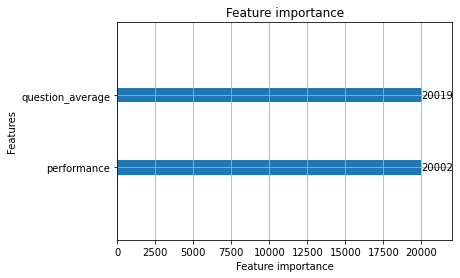

In [45]:
#displaying the most important features by split
lgb.plot_importance(model, importance_type = 'split')
plt.show()

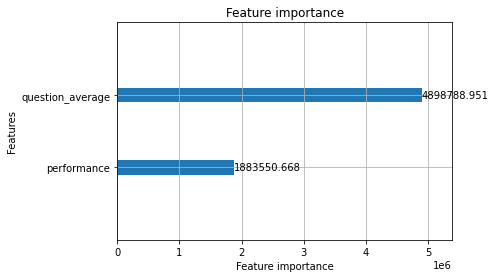

In [46]:
#displaying the most important features by gain
lgb.plot_importance(model, importance_type = 'gain')
plt.show()

# Modeling Test Dataset

This section is used only on Kaggle where there is an existing riiideducation python module from provider to control the flow of information to avoid us from using future data
Thus, we had to use the time-series API (iter-test) emulator to receive the test set and make predictions.

In [48]:
# Time-series API

# env = riiideducation.make_env()
# iter_test = env.iter_test()
# iter_nb = 0

In [53]:
# Loop through each batch of test dataset and update on dictionary to apply to model and receive predition

# for (current_df, sample_prediction_df) in iter_test:
#     if (iter_nb != 0):
#         prior_df = add_answers_to_prior_df(current_df,prior_df)
#         question_df = build_question_df(prior_df,question_df)
#         user_df = build_user_df(prior_df,user_df,question_df)
        
#     prior_df = current_df.copy()
#     current_df = data_transform(current_df,False,False)
#     current_df['answered_correctly'] = model.predict(current_df.iloc[:,1:])
#     iter_nb = 1
#     env.predict(current_df.loc[:, ['row_id', 'answered_correctly']])

In [54]:
# # Print out submission results
# submission = pd.read_csv('./submission.csv')
# submission.head(15)